<a href="https://colab.research.google.com/github/SenseNom/docs/blob/main/Final%20Project%20%3A%20Building%20a%20Rainfall%20Prediction%20Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [40]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier

In [20]:
url="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/_0eYOqji3unP1tDNKWZMjg/weatherAUS-2.csv"
df = pd.read_csv(url)
df.head()
df.count()

df=df.dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 56420 entries, 6049 to 142302
Data columns (total 23 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           56420 non-null  object 
 1   Location       56420 non-null  object 
 2   MinTemp        56420 non-null  float64
 3   MaxTemp        56420 non-null  float64
 4   Rainfall       56420 non-null  float64
 5   Evaporation    56420 non-null  float64
 6   Sunshine       56420 non-null  float64
 7   WindGustDir    56420 non-null  object 
 8   WindGustSpeed  56420 non-null  float64
 9   WindDir9am     56420 non-null  object 
 10  WindDir3pm     56420 non-null  object 
 11  WindSpeed9am   56420 non-null  float64
 12  WindSpeed3pm   56420 non-null  float64
 13  Humidity9am    56420 non-null  float64
 14  Humidity3pm    56420 non-null  float64
 15  Pressure9am    56420 non-null  float64
 16  Pressure3pm    56420 non-null  float64
 17  Cloud9am       56420 non-null  float64
 18  Cloud3p

In [21]:
df = df.rename(columns={'RainToday': 'RainYesterday',
                        'RainTomorrow': 'RainToday'})
df.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainYesterday,RainToday
6049,2009-01-01,Cobar,17.9,35.2,0.0,12.0,12.3,SSW,48.0,ENE,...,20.0,13.0,1006.3,1004.4,2.0,5.0,26.6,33.4,No,No
6050,2009-01-02,Cobar,18.4,28.9,0.0,14.8,13.0,S,37.0,SSE,...,30.0,8.0,1012.9,1012.1,1.0,1.0,20.3,27.0,No,No
6052,2009-01-04,Cobar,19.4,37.6,0.0,10.8,10.6,NNE,46.0,NNE,...,42.0,22.0,1012.3,1009.2,1.0,6.0,28.7,34.9,No,No
6053,2009-01-05,Cobar,21.9,38.4,0.0,11.4,12.2,WNW,31.0,WNW,...,37.0,22.0,1012.7,1009.1,1.0,5.0,29.1,35.6,No,No
6054,2009-01-06,Cobar,24.2,41.0,0.0,11.2,8.4,WNW,35.0,NW,...,19.0,15.0,1010.7,1007.4,1.0,6.0,33.6,37.6,No,No


In [22]:
df = df[df.Location.isin(['Melbourne','MelbourneAirport','Watsonia'])]
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7557 entries, 64191 to 80997
Data columns (total 23 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           7557 non-null   object 
 1   Location       7557 non-null   object 
 2   MinTemp        7557 non-null   float64
 3   MaxTemp        7557 non-null   float64
 4   Rainfall       7557 non-null   float64
 5   Evaporation    7557 non-null   float64
 6   Sunshine       7557 non-null   float64
 7   WindGustDir    7557 non-null   object 
 8   WindGustSpeed  7557 non-null   float64
 9   WindDir9am     7557 non-null   object 
 10  WindDir3pm     7557 non-null   object 
 11  WindSpeed9am   7557 non-null   float64
 12  WindSpeed3pm   7557 non-null   float64
 13  Humidity9am    7557 non-null   float64
 14  Humidity3pm    7557 non-null   float64
 15  Pressure9am    7557 non-null   float64
 16  Pressure3pm    7557 non-null   float64
 17  Cloud9am       7557 non-null   float64
 18  Cloud3pm

In [23]:
def date_to_season(date):
  month = date.month
  if (month == 12) or (month == 1) or (month==2):
    return 'Summer'
  elif (month == 3) or (month == 4) or (month==5):
    return 'Autumn'
  elif (month == 6) or (month == 7) or (month==8):
    return 'Winter'
  else:
    return 'Spring'

In [24]:
df['Date'] = pd.to_datetime(df['Date'])
df['Season'] = df['Date'].apply(date_to_season)
df=df.drop(columns='Date')
df.head()

,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,...,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainYesterday,RainToday,Season
64191,MelbourneAirport,11.2,19.9,0.0,5.6,8.8,SW,69.0,W,SW,...,37.0,1005.1,1006.4,7.0,7.0,15.9,18.1,No,Yes,Summer
64192,MelbourneAirport,7.8,17.8,1.2,7.2,12.9,SSE,56.0,SW,SSE,...,43.0,1018.0,1019.3,6.0,7.0,12.5,15.8,Yes,No,Summer
64193,MelbourneAirport,6.3,21.1,0.0,6.2,10.5,SSE,31.0,E,S,...,35.0,1020.8,1017.6,1.0,7.0,13.4,19.6,No,No,Summer
64194,MelbourneAirport,8.1,29.2,0.0,6.4,12.5,SSE,35.0,NE,SSE,...,23.0,1016.2,1012.8,5.0,4.0,16.0,28.2,No,No,Summer
64195,MelbourneAirport,9.7,29.0,0.0,7.4,12.3,SE,33.0,SW,SSE,...,31.0,1011.9,1010.3,6.0,2.0,19.4,27.1,No,No,Summer


In [32]:
X = df.drop(columns='RainToday', axis=1)
y = df['RainToday']

X.value_counts()

Location   MinTemp  MaxTemp  Rainfall  Evaporation  Sunshine  WindGustDir  WindGustSpeed  WindDir9am  WindDir3pm  WindSpeed9am  WindSpeed3pm  Humidity9am  Humidity3pm  Pressure9am  Pressure3pm  Cloud9am  Cloud3pm  Temp9am  Temp3pm  RainYesterday  Season
Watsonia   28.1     34.5     0.0       16.4         10.7      NNE          50.0           N           SW          19.0          19.0          31.0         44.0         1005.7       1006.6       7.0       6.0       29.6     27.8     No             Summer    1
Melbourne  2.3      15.2     0.0       1.0          8.6       NNE          31.0           N           N           15.0          15.0          87.0         43.0         1026.1       1022.1       1.0       3.0       3.9      13.9     No             Winter    1
           2.9      18.0     0.0       1.2          10.1      N            46.0           N           NNE         11.0          24.0          75.0         29.0         1023.8       1020.2       1.0       3.0       5.9      17.2     No             Autumn    1
           3.0      11.1     0.2       0.4          5.3       N            39.0           NNE         N           11.0          19.0          88.0         55.0         1021.1       1017.4       1.0       7.0       4.8      10.0     No             Winter    1
           3.1      12.5     0.0       1.2          2.5       N            54.0           N           N           19.0          30.0          81.0         58.0         1021.7       1017.6       7.0       7.0       6.5      12.0     No             Winter    1
                                                                                                                                                                                                                                                                ..
           3.4      14.4     0.0       1.2          7.6       N            33.0           N           ESE         11.0          6.0           84.0         45.0         1023.0       1017.6       1.0       7.0       4.8      13.7     No             Winter    1
           3.2      14.3     0.0       1.6          5.1       N            37.0           N           N           19.0          26.0          75.0         48.0         1028.1       1023.5       2.0       7.0       6.0      13.3     No             Winter    1
                    13.5     0.0       1.2          1.3       N            31.0           N           NNW         24.0          11.0          73.0         90.0         1023.8       1023.4       7.0       7.0       6.0      10.7     No             Winter    1
           3.1      16.1     0.0       1.8          8.1       N            56.0           N           N           20.0          28.0          77.0         45.0         1028.1       1024.3       1.0       3.0       9.7      15.6     No             Winter    1
                    15.2     0.0       1.8          9.5       NNE          43.0           N           NNE         15.0          22.0          80.0         40.0         1032.9       1030.2       1.0       1.0       4.5      14.5     No             Winter    1
Name: count, Length: 7557, dtype: int64

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=42)

In [34]:
numeric_features = X_train.select_dtypes(include=['number']).columns.tolist()
categorical_features = X_train.select_dtypes(include=['object','category']).columns.tolist()

In [37]:
numeric_transformer = Pipeline(steps=[
    ('Scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('OneHot', OneHotEncoder(handle_unknown='ignore'))
])


In [38]:
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])


In [41]:
from random import Random
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

In [42]:
param_grid = {
    'classifier__n_estimators': [50,100],
    'classifier__max_depth':[None, 10,20],
    'classifier__min_samples_split':[2,5,10]

}

In [43]:
cv = StratifiedKFold(n_splits=5, shuffle=True)

In [46]:
grid_search = GridSearchCV(pipeline, param_grid, cv=cv, scoring='accuracy')
grid_search.fit(X_train, y_train)

print("Best parameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)

Best parameters:  {'classifier__max_depth': None, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 100}
Best score:  0.8492969396195201


In [47]:
test_score = grid_search.score(X_test, y_test)
print("Test score: ", test_score)

Test score:  0.8544973544973545


In [48]:
y_pred = grid_search.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          No       0.87      0.95      0.91      1168
         Yes       0.76      0.53      0.62       344

    accuracy                           0.85      1512
   macro avg       0.82      0.74      0.77      1512
weighted avg       0.85      0.85      0.84      1512



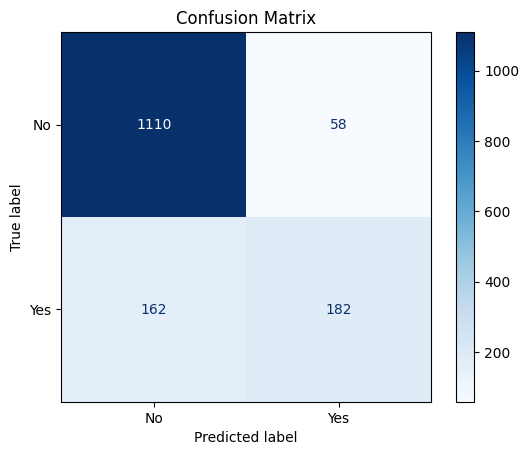

In [50]:
conf_matrix = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=grid_search.classes_)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

In [51]:
feature_importances = grid_search.best_estimator_['classifier'].feature_importances_


In [57]:
pipeline.set_params(classifier=LogisticRegression(random_state=42))
grid_search.estimator = pipeline
param_grid = {
    'classifier__solver': ['liblinear'],
    'classifier__penalty': ['l1', 'l2'],
    'classifier__class_weight': [None, 'balanced']

}

grid_search.param_grid = param_grid
grid_search.fit(X_train, y_train)

y_pred = grid_search.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          No       0.87      0.93      0.90      1168
         Yes       0.69      0.51      0.59       344

    accuracy                           0.84      1512
   macro avg       0.78      0.72      0.74      1512
weighted avg       0.83      0.84      0.83      1512

